## HOMEWORK 4
## 1) Does basic house information reflect house's description?

In this part of the homework our task is to perform a clustering analysis of house announcements in Rome from Immobiliare.it. We will create two datasets by retrieving data from websites. Then, we will
implement two clustering methods and compare the results.

**Python Libraries:**

In [1]:
import time
import threading
import requests
from bs4 import BeautifulSoup
import re
import csv
import pandas as pd

# for the clustering part:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

# our external module:
import collect_data
import prepare_tfid

### **Scraping data**

As the first step, we are collecting the list of interesting urls, starting from the website:
https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1.

+ We are using the time.sleep function to prevent the websie blocking.
+ The implementation of "thread_find_links" function is located in the external file **collect_data.py**

In [ ]:
link_threads = []
for nr_page in range(1, 100):
    t = threading.Thread(target=collect_data.thread_find_links, args=("nr_page",))
    t.start()
    time.sleep(1)

+ We are saving collected links into **links.txt** file

In [64]:
print("The number of collected links: {}".format(len(link_threads)))

The number of collected links: 25974


In [ ]:
with open("links.txt", "w") as link_file:
    for url_ in link_threads:
        link_file.write(url_)

In [8]:
# Load data from link.txt 
with open("links.txt", "r") as link_file:
    link_threads = link_file.readlines()

+ We are iterating through collected links to retrieve and save data about flats. 
+ For this, we defined the fuction **threadExtract**. 
+ We applied the parallel programming by generating threads for each url. 

In [27]:
def threadExtract(url):
    """
    This function gets html content and scraps the interesting data
    Input: String: "url" 
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    # use defined function for retrieving data from websites
    scrapped_data = collect_data.scrap_data(soup)
    if scrapped_data != None:
        datawriter.writerow(scrapped_data)

+ The collected data are saved in **flat_data.txt** file.

In [33]:
# data_file = open("flat_data.txt", "w", encoding='utf-8')
headers = ["price", "locali", "superficie", "bagni", "piano", "description"]
datawriter = csv.writer(data_file)
datawriter.writerow(headers)

49

In [ ]:
failed_links = []

def create_threads(from_, to_):
    for link_ in link_threads[from_ : to_]:
        # try collect data from the website
        try:
            threading.Thread(threadExtract(link_[:-1])).start() #-1 because we have "\n" in the end of a link
            time.sleep(3) #for non-blocking
        except Exception as e:
            print(e)
            failed_links.append(link_)

In [ ]:
# Run threads for previously collected links: 
for rep in range(0, 20000, 100):
    create_threads(from_= rep, to_ = rep+100)

data_file.close()

### Datasets

We are reading the **flat_data.txt** file content as dataframe.
Then, we are splitting the collected data into two separated datasets:
+ **Information dataset** : [price, locali, superficie, bagni, piano]
+ **Description dataset** : [TFIDF matrix for descriptions]

In [59]:
data_frame = pd.read_csv("flat_data.txt")

In [60]:
data_frame.head()

,price,locali,superficie,bagni,piano,description
0,1260000,5,225,2,4,In stabile signorile in Via Appia Nuov...
1,245000,2,80,1,2,Rif: G118 - APPIA NUOVA STATUARIO Via ...
2,319000,3,114,1,1,proponiamo in vendiata ampio e luminos...
3,630000,4,153,2,5,Rif: 20141 - Appartamento composto da ...
4,157000,3,68,1,1,Proponiamo la vendita di un trilocale ...


In [3]:
print("We managed to collect data about {} announcements".format(len(data_frame)))

We managed to collect data about 10544 announcements


**Information dataset**

In [39]:
inf_dataset = data_frame[["price", "locali", "superficie", "bagni", "piano"]]
inf_dataset.head()

,price,locali,superficie,bagni,piano
0,1260000,5,225,2,4
1,245000,2,80,1,2
2,319000,3,114,1,1
3,630000,4,153,2,5
4,157000,3,68,1,1


**Description Dataset**

+ In order to create the TFIDF matrix (Description Dataset), we defined the function **generate_tfidf_matrix**, which as an input takes the dataframe with column "description" for all annoucements. The implementation is located in the external file **collect_data.py**

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
from nltk.tokenize import word_tokenize, regexp_tokenize
from collections import defaultdict
import numpy as np

def preprocess(text):
    text = text.lower()
    # removing '\n'
    text = text.replace('\\n', ' ')
    # removing punctuation
    tokenizer = regexp_tokenize(text, "[\w\$]+")
    # removing numbers
    filtered = [w for w in tokenizer if not w.isnumeric()]
    # filter the non stopwords
    filtered = [w for w in filtered if not w in stopwords.words('italian')]
    its = ItalianStemmer()
    # removing the stem
    filtered = [its.stem(word) for word in filtered]
    return filtered

In [42]:
# PREPROCESSING AND CREATING VOCABULARY FILE
def create_and_save_vocabulary()
    vocabulary_set = set()
    annouc_list = []
    occurence_words_list = []

    # open file with our data
    with open("flat_data.txt", "r" ,encoding="utf-8") as flat_data:
        reader = csv.reader(flat_data, delimiter=",")
        for i, line in enumerate(reader):
            #if i%100==0: print(i) #to see the progress of calculations
            if line != [] and i!=0:
                # preprocess the dictionary text
                description = preprocess(line[5])
                # put new words to vocabulary set
                vocabulary_set.update(description)
                # put prepared words into the list with all announcements
                annouc_list.append(set(description))
                # count words frequency
                freq_word_dict = {}
                for w in description:
                    try: freq_word_dict[w] += 1
                    except: freq_word_dict[w] = 1
                # save the frequency dict for words in description 
                occurence_words_list.append(freq_word_dict)
    return occurence_words_list

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [44]:
# save all collected words into "vocabulary.txt" file       
vocabulary = {k:v for v, k in enumerate(vocabulary_set)}
voc_file = open("vocabulary.txt", 'w', encoding = "utf8")
for term in vocabulary:
    voc_file.write('{0}\t{1}\n'.format(term, vocabulary[term]))
voc_file.close()

In [45]:
# CREATING INVERTED INDEX --> id_word: announcements where the word occurs
# iterate through the annoucements and for each word inside them create inverted index
# inverted index dictionary has a structure --> id_word: announcements where the word occurs
inv_indx = defaultdict(set)
for idx, words in enumerate(annouc_list):
    for word in words:
        inv_indx[vocabulary[word]].add(idx)

# SAVE TO FILE - inverted_indx.txt
inv_file = open("inverted_indx.txt", 'w', encoding = "utf8")
for id_word, docks in inv_indx.items():
    inv_file.write('{0}\t{1}\n'.format(id_word, '\t'.join(map(str, docks))))
inv_file.close()

In [34]:
# # remove outliers = remove words with maximum and minimum number of occurence in annoucements
# ann_lenghts = [len(annoucs) for annoucs in inv_indx.values()]
# outliers_values = [max(ann_lenghts), min(ann_lenghts)]

In [55]:
global tfid
inv_indx_tfid = {}
tfid = {}
numWords = len(freq_dict)
# inverted Index dictionary with the TFID scores

def computeTFID(freq_dict, doc_id, tot_num_docs, inv_indx):
    tfid_per_annoucement = {}
    for word in freq_dict.keys():
        word_id = vocabulary[word]
        num_in_annouc = len(inv_indx[word_id])
        log_part = np.log(float(tot_num_docs)/num_in_annouc)
        tfid_per_annoucement[word_id] = round(float(freq_dict[word])/numWords * log_part, 5)
#         tfid_list.append((word_id, round(float(freq_dict[word])/numWords * log_part, 3)))
    tfid[doc_id] = tfid_per_annoucement
    return

len_rows = len(docs_list)
for doc_id, freq_dict in enumerate(occurence_words_list): 
    computeTFID(freq_dict, doc_id, len_rows, inv_indx)

In [73]:
type(tfid)

dict

In [74]:
# save tfid
tfid_file = open("tfid.csv", 'w', encoding = "utf8")
for id_annouc, words_jacc_dict in tfid.items():
    tfid_file.write('{0}\t{1}\n'.format(id_annouc, '\t'.join(map(str, words_jacc_dict.keys()))))
tfid_file.close()


In [64]:
dict_df = pd.DataFrame(columns=[i for i in range(len(vocabulary))])
for i in range(len(tfid)):
    dict_df = dict_df.append(tfid[i], ignore_index=True)

# change Nan values to 0.
dict_df = dict_df.fillna(0)
dict_df

,0,1,2,3,4,5,6,7,8,9,...,753,754,755,756,757,758,759,760,761,762
0,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,-0.0538,0.00000,0.0000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,-0.0538,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,-0.04501,0.0000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,-0.04501,-0.0538,-0.05610,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
4,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,-0.0538,0.00000,0.0000,0.00000,-0.04501
5,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
6,0.00000,0.00000,0.00000,0.00000,0.0000,-0.04501,0.00000,0.00000,0.0000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000
7,0.00000,0.00000,0.00000,0.00000,-0.0561,0.00000,0.00000,0.00000,0.0000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,-0.0561,0.00000,0.00000
8,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,-0.05054,0.00000,0.0000,0.00000,...,0.00000,0.00000,0.00000,-0.05054,0.00000,-0.0538,0.00000,0.0000,0.00000,0.00000
9,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.0000,0.00000,0.00000


In [66]:
dict_df.index.name = "Ann_index"

In [68]:
dict_df.to_csv("description_matrix.csv")

In [6]:
def generate_tfidf_matrix():
    ###
    return tfidf_matrix

#m_i_j - i rows- annoucements, j- words

### Clustering

####  K-means++

This part consists of clustering the house announcements using K-means++ method. 
In order to choose the optimal number of clusters we used the Elbow-Method.

+ We are iterating through a different number of cluster "k"
+ Clusters are saved as an additional column in a dataframe

In [56]:
# INFORMATION DATASET

sse = {}
for k in range(1,4):
    kmeanModel = KMeans(n_clusters=k, max_iter=1000).fit(inf_dataset)
    # save clusters in df
    inf_dataset['clusters'+str(k)] = kmeanModel.labels_
    sse[k] = kmeanModel.inertia_ # check it

In [57]:
inf_dataset.head()

,price,locali,superficie,bagni,piano,clusters,clustersk,clusters1,clusters2,clusters3
0,1260000,5,225,2,4,2,1,0,1,1
1,245000,2,80,1,2,1,0,0,0,0
2,319000,3,114,1,1,1,0,0,0,0
3,630000,4,153,2,5,0,2,0,0,2
4,157000,3,68,1,1,1,0,0,0,0


+ According to the plot, the best values are..

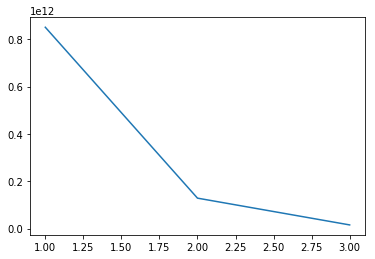

In [60]:
# plotting the elbow-method results
plt.figure()
plt.xlabel = "k - Number of clusters "  # TODO: Why we do not have titles? ??????
plt.ylabel = "SSE (Inertia)"
plt.title = "Plot of SSE for kmeans clustering"
plt.plot(list(sse.keys()), list(sse.values()))
plt.show()

In [61]:
# TODO: paste more code from HM4_Asia